In [1]:
!pip install --upgrade keras-hub tensorflow-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 12.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 3.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.18.1
    Uninstalling keras-hub-0.18.1:
      Successfully uninstalled keras-hub-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.19.1 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [48]:
#import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# The distribution API is only implemented for the JAX backend for now.
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [4]:
import jax
import jax.numpy as jnp

In [5]:
import keras
keras.mixed_precision.set_global_policy("mixed_bfloat16")
import keras_hub

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import json
import re
import string
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [7]:
#import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import tensorflow_text as tf_text


In [8]:
from keras import layers, models, losses, callbacks

In [9]:
gpus=jax.devices()

E0000 00:00:1741160372.047487    1474 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [10]:
gpus

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [11]:
#gpus = tf.config.list_physical_devices('TPU')
num_gpus=len(gpus)
print("Num GPUs Available: ", num_gpus)

Num GPUs Available:  8


## Configuration

In [12]:
VOCAB_SIZE = 5000 # 50000 is the size of the vocabulary for gpt2 on common corpus. Simplebooks is smaller
MAX_LEN = 1024 # the maximum length of the input sequences,
EMBEDDING_DIM = 768 # the dimension of the word embeddings
N_HEADS = 8 #  the number of attention heads
NUM_BLOCKS = 8 # Number of transformer blocks 12 in gpt2, 3 in gpt nano
FEED_FORWARD_DIM = 4*EMBEDDING_DIM #  the dimension of the feed-forward network in the block
VALIDATION_SPLIT = 0.2 # the fraction of data to be used for validation
SEED = 42 # the random seed for reproducibility
MIN_STRING_LEN = 128  # Strings shorter than this will be discarded
SEQ_LEN = 128 # 512  # Length of training sequences, in tokens

In [13]:
# Data
BATCH_SIZE = 128*num_gpus # the size of the batches for training

In [14]:
BASE_DIR="/kaggle/working"

## Data ingestion and pre-processing

In [ ]:
keras.utils.get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
    cache_subdir=BASE_DIR+"/keras/",
)


In [15]:
dir = BASE_DIR+"/keras/simplebooks.zip/simplebooks/"

In [16]:
# Load simplebooks-92 train set and filter out short lines.
raw_train_ds = (
    tf_data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
    .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
    .batch(BATCH_SIZE, drop_remainder=True)
    .shuffle(buffer_size=256)
)

# Load simplebooks-92 validation set and filter out short lines.
raw_val_ds = (
    tf_data.TextLineDataset(dir + "simplebooks-92-raw/valid.txt")
    .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
    .batch(BATCH_SIZE, drop_remainder=True)
)

In [17]:
raw_val_ds

<_BatchDataset element_spec=TensorSpec(shape=(1024,), dtype=tf.string, name=None)>

In [18]:
for element in raw_val_ds.take(1):
    print(element)

tf.Tensor(
[b'Out of his box the Jack popped his head. The funny, black fringe of whiskers around his face jiggled up and down. His queer, big eyes looked around the store.'
 b'"There is no one in the department but us toys," said a Calico Clown, and he banged together some shiny cymbals on the ends of his arms. "The Jack is right -- we are all by ourselves."'
 b'"I am glad of it," said a woolly Lamb on Wheels, who stood on the floor, just under the edge of the toy counter. She was rather too large to be up among the smaller toys. "Yes, I am glad of it," went on the Lamb. "I have kept still all day, and now I have something to tell you all, my friends."'
 ...
 b'And Baldy was right. Some hours after the Curlytops were back at Ring Rosy Ranch, in rode Uncle Frank and the others. They had not found what they had gone after, and you can imagine how surprised they all were when told that Ted and Janet had, by accident, found the lost cattle and horses in the hidden valley.'
 b'"I knew they

## Tokenization

### Train and save vocabulary

In [ ]:
# Train tokenizer vocabulary
vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

In [ ]:
import pickle
with open(BASE_DIR+'/simplebooks_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

### Or read it back

In [19]:
#insert code to save and retrieve tokenizer
import pickle
with open('/kaggle/input/simplebooks-vocabulary/simplebooks_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [20]:
vocab[100:120]

['that',
 'it',
 'had',
 '##s',
 'his',
 'as',
 'for',
 'with',
 'they',
 'on',
 'but',
 'her',
 'at',
 'she',
 'were',
 'not',
 'you',
 'be',
 'him',
 'all']

In [21]:
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

In [22]:
# packer adds a start token
start_packer = keras_hub.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)

def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)

## Distribution strategy


### EITHER FSDP
Implement FSDP by sharding both data and model along the same dimension. In this way, we can use a batch size of 2*num_gpus. Data parallel would be more efficient in terms of comms, but the batch size would be limited to num_gpus (in this specific example)

In [ ]:
#del (layout_map, device_mesh )

In [23]:
## FSDP ##

# Or you can choose to create DataParallel with a 1D `DeviceMesh`.
device_mesh = keras.distribution.DeviceMesh(
    shape=(num_gpus,), axis_names=["model"], devices=gpus
)
layout_map = keras.distribution.LayoutMap(device_mesh)

# Partitioning for embeddings (regex)
layout_map["embedding/embeddings"] = ( None, "model")

# Partitioning (regex) for attention layer weights
layout_map["transformer_decoder_\d+.*self_attention.*(query|key|value).*kernel"] = (None, "model", None)
layout_map["transformer_decoder_\d+.*self_attention/attention_output.*kernel"] = (None, None, "model")
layout_map["transformer_decoder_\d+.*feedforward_intermediate_dense.*kernel"] = ("model", None)
layout_map["transformer_decoder_\d+.*feedforward_output_dense.*kernel"] = (None, "model")

layout_map["outputs/kernel"] = ( None, "model")

##FSDP##
model_parallel = keras.distribution.ModelParallel(layout_map=layout_map, batch_dim_name="model")

keras.distribution.set_distribution(model_parallel)

### Or Model-Parallel

In [ ]:
## MODEL PARALLEL ##

device_mesh=keras.distribution.DeviceMesh(
    shape=(1,num_gpus),
    axis_names=["data", "model"],
    devices=gpus
)
layout_map = keras.distribution.LayoutMap(device_mesh)
# Partitioning for embeddings (regex)
layout_map["embedding/embeddings"] = ( None, "model")

# Partitioning (regex) for attention layer weights
layout_map["transformer_decoder_\d+.*self_attention.*(query|key|value).*kernel"] = (None, "model", None)
layout_map["transformer_decoder_\d+.*self_attention/attention_output.*kernel"] = (None, None, "model")
layout_map["transformer_decoder_\d+.*feedforward_intermediate_dense.*kernel"] = ("model", None)
layout_map["transformer_decoder_\d+.*feedforward_output_dense.*kernel"] = (None, "model")

layout_map["outputs/kernel"] = ( None, "model")


##Hybrid DP/MP
model_parallel = keras.distribution.ModelParallel(layout_map=layout_map, batch_dim_name="data")

keras.distribution.set_distribution(model_parallel)


### OR data-parallel

In [ ]:
data_parallel = keras.distribution.DataParallel(devices=gpus)
keras.distribution.set_distribution(data_parallel)

## Create model

In [24]:
@keras.saving.register_keras_serializable()
class SwiGLU(keras.layers.Layer):
    def __init__(self, intermediate_size, **kwargs):
        super(SwiGLU, self).__init__(**kwargs)
        self.intermediate_size = intermediate_size

    def build(self, input_shape):
        last_dim = input_shape[-1]
        self.W1 = self.add_weight(shape=(last_dim, self.intermediate_size), initializer='glorot_uniform', trainable=True, name='W1')
        self.W2 = self.add_weight(shape=(last_dim, self.intermediate_size), initializer='glorot_uniform', trainable=True, name='W2')
        self.V = self.add_weight(shape=(self.intermediate_size,), initializer='zeros', trainable=True, name='V')
        super(SwiGLU, self).build(input_shape)

    def call(self, inputs):
        gate = jax.nn.sigmoid(inputs @ self.W1 + self.V)
        return gate * (inputs @ self.W2)

    def get_config(self):
        config = super(SwiGLU, self).get_config()
        config.update({'intermediate_size': self.intermediate_size})
        return config

In [24]:
## From Llama
decay_steps = 1.2E5
initial_learning_rate = 0.0
alpha=0.1
warmup_steps = 200
target_learning_rate = 3e-4
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps,
    warmup_target=target_learning_rate,
    warmup_steps=warmup_steps,
    alpha=alpha
)
optimizer=keras.optimizers.AdamW(learning_rate=learning_rate,
                                weight_decay=0.1,
                                beta_1=0.9,
                                beta_2=0.95,
                                epsilon=1e-5,
                                )

In [25]:
inputs = keras.layers.Input(shape=(None,),dtype="int32")

# Embedding.

x=layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, dtype="bfloat16", name="embedding")(inputs)
x=keras_hub.layers.RotaryEmbedding(dtype="bfloat16", name="rope")(x)

#embedding_layer = keras_hub.layers.TokenAndPositionEmbedding(
#    vocabulary_size=VOCAB_SIZE,
#    sequence_length=SEQ_LEN,
#    embedding_dim=EMBEDDING_DIM,
#    mask_zero=True,
#)
#x = embedding_layer(inputs)

# Transformer decoders.
for i in range(NUM_BLOCKS):
    decoder_layer = keras_hub.layers.TransformerDecoder(
        num_heads=N_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
        dropout=0.1,
        activation=SwiGLU(intermediate_size=FEED_FORWARD_DIM), #"gelu",
        normalize_first=True,
        layer_norm_epsilon=1e-5,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        dtype="bfloat16",
        name=f"transformer_decoder_{i}",
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.

# Output.
outputs = keras.layers.Dense(VOCAB_SIZE, dtype="float32", name="outputs")(x)
gpt = keras.Model(inputs=inputs, outputs=outputs, name="gpt2")
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_hub.metrics.Perplexity(from_logits=True, mask_token_id=0)
gpt.compile(optimizer=optimizer,
            loss=loss_fn, metrics=[perplexity])


In [26]:
gpt.summary()

Model: "gpt2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 768)      │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rope (RotaryEmbedding)          │ (None, None, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_0           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_1           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_2           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_3           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_4           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_5           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_6           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_7           │ (None, None, 768)      │     7,087,872 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, None, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, None, 5000)     │     3,845,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,387,976 (130.14 MB)

 Trainable params: 64,387,976 (130.14 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
for v in gpt.variables:
    print(v.path, v.shape)

embedding/embeddings (5000, 768)
transformer_decoder_0/self_attention/query/kernel (768, 8, 96)
transformer_decoder_0/self_attention/query/bias (8, 96)
transformer_decoder_0/self_attention/key/kernel (768, 8, 96)
transformer_decoder_0/self_attention/key/bias (8, 96)
transformer_decoder_0/self_attention/value/kernel (768, 8, 96)
transformer_decoder_0/self_attention/value/bias (8, 96)
transformer_decoder_0/self_attention/seed_generator/seed_generator_state (2,)
transformer_decoder_0/self_attention/attention_output/kernel (8, 96, 768)
transformer_decoder_0/self_attention/attention_output/bias (768,)
transformer_decoder_0/self_attention_layer_norm/gamma (768,)
transformer_decoder_0/self_attention_layer_norm/beta (768,)
transformer_decoder_0/seed_generator_1/seed_generator_state (2,)
transformer_decoder_0/feedforward_intermediate_dense/kernel (768, 3072)
transformer_decoder_0/feedforward_intermediate_dense/bias (3072,)
transformer_decoder_0/feedforward_output_dense/kernel (3072, 768)
transf

## Train Model

In [28]:
from datetime import datetime

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=BASE_DIR+"/models/checkpoints/gpu/llama2-tpu-"+datetime.now().strftime("%Y%m%d-%H%M%S")+".keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1)

In [44]:
earlystop=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [45]:
tensorboard=keras.callbacks.TensorBoard(
    log_dir=BASE_DIR+"/logs",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=5,
    embeddings_metadata=None,
)

In [32]:
%%time
history=gpt.fit(train_ds,
                validation_data=val_ds,
                epochs=20,
                callbacks=[checkpoint, earlystop, tensorboard],
                verbose=1)

Epoch 1/20
    997/Unknown 601s 538ms/step - loss: 3.4928 - perplexity: 491.4618
Epoch 1: val_loss improved from inf to 1.82319, saving model to /kaggle/working/models/checkpoints/gpu/llama2-tpu-20250305-025922.keras
997/997 ━━━━━━━━━━━━━━━━━━━━ 650s 587ms/step - loss: 3.4922 - perplexity: 491.1012 - val_loss: 1.8232 - val_perplexity: 51.7369
Epoch 2/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 2.5069 - perplexity: 64.4064
Epoch 2: val_loss improved from 1.82319 to 1.64671, saving model to /kaggle/working/models/checkpoints/gpu/llama2-tpu-20250305-025922.keras
997/997 ━━━━━━━━━━━━━━━━━━━━ 591s 566ms/step - loss: 2.5069 - perplexity: 64.3994 - val_loss: 1.6467 - val_perplexity: 35.3622
Epoch 3/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 2.3110 - perplexity: 46.0831
Epoch 3: val_loss improved from 1.64671 to 1.56907, saving model to /kaggle/working/models/checkpoints/gpu/llama2-tpu-20250305-025922.keras
997/997 ━━━━━━━━━━━━━━━━━━━━ 592s 566ms/step - loss: 2.3110 - perp

### Plot losses

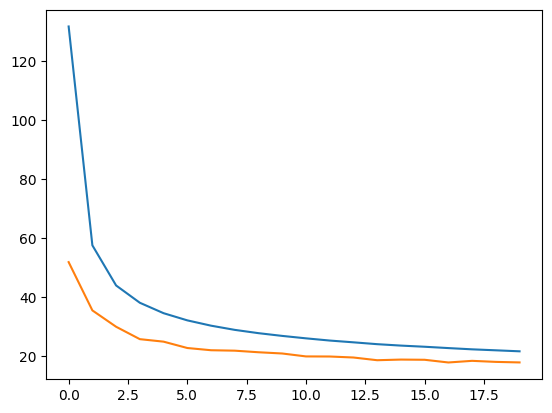

In [34]:
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])

In [ ]:
# Load the TensorBoard notebook extension if available
%load_ext tensorboard

In [ ]:
# May work in colab but not kaggle
%tensorboard --logdir $BASE_DIR/logs

In [26]:
gpt.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - loss: 1.3326 - perplexity: 18.1635


[1.3271245956420898, 17.708637237548828]

## Save pre-trained model

In [27]:
gpt.save(BASE_DIR+'/models/gpt2-simplebooks-pt-tpu.keras')

## Inference with pre-trained model

In [25]:
gpt=keras.saving.load_model("/kaggle/working/models/checkpoints/gpu/llama2-tpu-20250305-025922.keras",
                            custom_objects={"SwiGLU": SwiGLU, }, compile=True, safe_mode=True)

In [28]:
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

Array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],      dtype=int32)

In [29]:
def next(prompt, cache, index):
    logits = gpt(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache


### Test different samplers

In [ ]:
sampler = keras_hub.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

In [ ]:
sampler = keras_hub.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

In [ ]:
sampler = keras_hub.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

In [30]:
sampler = keras_hub.samplers.TopPSampler(p=0.8, k=5, temperature=1.2)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
['[BOS] when the first rays of the rising sun shone on the water the little girl was delighted with the idea . she could hardly believe her eyes when she saw that she was not at all frightened at first , but she thought that she would be able to see her mother , and that , if the wind should blow , she would not be able to tell her . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']



In [31]:
sampler = keras_hub.samplers.TopKSampler(k=5, temperature=1.2)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

Top-K search generated text: 
['[BOS] " i am glad to meet you , my son , " said the old man , " but i have not been here long , for i have been here long enough to have seen you and heard the whole story of your adventures and adventures in the far - off lands of the far - off world . " [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']



### Give an instruction

In [32]:
prompt_tokens = start_packer(tokenizer(["Write a list of 3 ingredients for a sandwich"]))
prompt_tokens

Array([[   2, 1267,   36, 3708,   96,   20,   97,  613,  521, 2760,  103,
         106,   36, 1556,  883, 4559,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [33]:
sampler = keras_hub.samplers.TopPSampler(k=5, p=0.8, seed=SEED, temperature=1.0)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

Top-K search generated text: 
['[BOS] " well , it \' s a pretty good idea , anyhow , " said the man , with a laugh , as he looked at the boy and his wife , who were still in his room . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']



## Optional: Keep training with callbacks

In [ ]:
class TopKTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-k."""

    def __init__(self, k, temperature):
        self.sampler = keras_hub.samplers.TopKSampler(k=k, temperature=temperature)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"\nTop-K search generated text: \n{txt}\n")


text_generation_callback = TopKTextGenerator(k=10, temperature=1.0)



In [ ]:
class TopPTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-p."""

    def __init__(self, p, k, temperature):
        self.sampler = keras_hub.samplers.TopPSampler(p=p, k=k, temperature=temperature)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"\nTop-P search generated text: \n{txt}\n")


text_generation_callback = TopPTextGenerator(p=0.8, k=10, temperature=1.2)



### Training with callbacks

In [ ]:
# Dummy training loop to demonstrate callback.
gpt.fit(train_ds.take(1), verbose=1, epochs=2, callbacks=[text_generation_callback])

In [ ]:
# Training loop with callbacks
gpt.fit(train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[earlystop, text_generation_callback])

## Instruction Tuning

In [34]:
import pandas as pd

In [35]:
df = pd.read_parquet("hf://datasets/vicgalle/alpaca-gpt4/data/train-00000-of-00001-6ef3991c06080e14.parquet")

In [36]:
df.head()

,instruction,input,output,text
0,Give three tips for staying healthy.,,1. Eat a balanced and nutritious diet: Make su...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,An atom is the basic building block of all mat...,Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are several ways to reduce air pollution...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,"As an AI assistant, I do not have my own perso...",Below is an instruction that describes a task....


In [37]:
ds=tf_data.Dataset.from_tensor_slices(df["text"]).batch(BATCH_SIZE, drop_remainder=True)

In [38]:
for element in ds.take(1):
    print (element)

tf.Tensor(
[b'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'
 b'Below is an instruction that describes a 

In [39]:
ids=ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(tf_data.AUTOTUNE)

In [40]:
train_ids, val_ids=keras.utils.split_dataset(ids, left_size=0.8, shuffle=True, seed=SEED)

In [41]:
for element in val_ids.take(1):
    print (element)

(<tf.Tensor: shape=(1024, 128), dtype=int32, numpy=
array([[   2,  716,  121, ...,   27, 3720,   13],
       [   2,  716,  121, ...,    0,    0,    0],
       [   2,  716,  121, ...,   93,  251,   38],
       ...,
       [   2,  716,  121, ...,   40, 3663,  430],
       [   2,  716,  121, ..., 1870,   35,   95],
       [   2,  716,  121, ...,  577,  131,  386]], dtype=int32)>, <tf.Tensor: shape=(1024, 128), dtype=int32, numpy=
array([[ 716,  121,  141, ..., 3720,   13, 1225],
       [ 716,  121,  141, ...,    0,    0,    0],
       [ 716,  121,  141, ...,  251,   38,  162],
       ...,
       [ 716,  121,  141, ..., 3663,  430, 2760],
       [ 716,  121,  141, ...,   35,   95,   61],
       [ 716,  121,  141, ...,  131,  386,   96]], dtype=int32)>)


In [ ]:
text_generation_callback = TopPTextGenerator(p=0.8, k=5, temperature=0.3)

In [46]:
# Training loop with callbacks
it_history= gpt.fit(train_ids,
                    validation_data=val_ids,
                    epochs=20,
                    callbacks=[earlystop,
                               #text_generation_callback,# too slow on Kaggle
                               tensorboard],
                    verbose=1
                   )

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - loss: 2.3805 - perplexity: 15.7126 - val_loss: 1.4506 - val_perplexity: 4.5835
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.4327 - perplexity: 4.5113 - val_loss: 1.2807 - val_perplexity: 3.8378
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.2603 - perplexity: 3.7638 - val_loss: 1.1849 - val_perplexity: 3.4713
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1462 - perplexity: 3.3382 - val_loss: 1.1335 - val_perplexity: 3.2894
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.0661 - perplexity: 3.0687 - val_loss: 1.1174 - val_perplexity: 3.2343
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 1.0093 - perplexity: 2.8908 - val_loss: 1.0876 - val_perplexity: 3.1334
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.9503 - perplexity: 2.7168 - val_loss: 1.0740 - val_perplexity: 3.0895
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.9021 - perplexity: 2.5827 - 

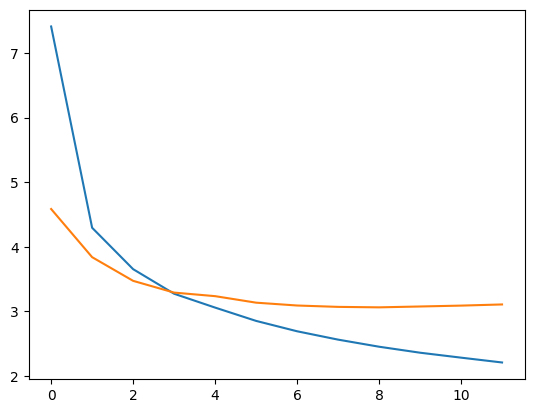

In [49]:
plt.plot(it_history.history['perplexity'])
plt.plot(it_history.history['val_perplexity'])

In [50]:
gpt.save(BASE_DIR+'/models/gpt2-simplebooks-it-tpu.keras')

## Inference with i.t. model

In [51]:
prompt_tokens = start_packer(tokenizer(["""Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.\n\n
### Instruction:\nWrite a list of three ingredients for a sandwich.\n\n
### Response: """ ]))
prompt_tokens

Array([[   2,  716,  121,  141,   97,  485, 4111,  100, 4385,  103,   36,
        2027,   13, 1402,  135,  107,  141,   97,  541, 1341,  100,   51,
        2598, 3101,  103,  821,   38,  270,  730,  853,  202,   15, 1267,
          36,  734,  103,  541, 1382,  180,  100,   36,  541,  541, 4029,
        2623,  730,  148, 2144,  103,   93, 3025,   15,    1,    1,    1,
          97,  485, 4111,   27, 1267,   36, 3708,   96,  240,   97,  613,
         521, 2760,  103,  106,   36, 1556,  883, 4559,   15,    1,    1,
           1,  734,  103,  541, 1382,  180,   27,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [52]:
np.where(prompt_tokens.flatten()==0)[0][0]

np.int64(84)

In [60]:
sampler = keras_hub.samplers.TopPSampler(k=3,
                                         p=0.8,
                                         seed=SEED,
                                         temperature=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=np.where(prompt_tokens.flatten()==0)[0][0],
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
['[BOS] below is an instruction that describes a task , paired with an input that provides further context . write a response that appropriately completes the request . [UNK] [UNK] [UNK] instruction : write a list of three ingredients for a sandwich . [UNK] [UNK] [UNK] response : 1 . garlic bread 2 . eggs 3 . broccoli 4 . pumpkin 4 . chicken 5 . chicken [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']

